In [2]:
import sys

sys.path.append('../image_lddmm_tensorflow/')

import numpy as np # for arrays
%matplotlib inline
import matplotlib as mpl # for graphics
import matplotlib.pyplot as plt
import seaborn as sns

# import nipy

import nibabel.processing
import nibabel as nib # for loading neuroimages
import vis # visualization
import imp # use imp.reload to update modules during development

ModuleNotFoundError: No module named 'nipy'

In [3]:
# get filenames
atlas_image_fname = "/home/adam2392/hdd/data/neuroimaging/freesurfer_output/outputfiles/la03/resectionvolume/preT1.mgz"
target_image_fname = "/home/adam2392/hdd/data/neuroimaging/freesurfer_output/outputfiles/la03/resectionvolume/postT1.mgz"

atlas_image_fname = "/home/adam2392/hdd/data/neuroimaging/freesurfer_output/outputfiles/la03/T1.mgz"
target_image_fname = "/home/adam2392/hdd/data/neuroimaging/freesurfer_output/outputfiles/la03/resectionvolume/post_in_pre_T1_robustregistration_normalize.mgz"

In [7]:
# load them with nibabel
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [8]:
# get info about image space
if '.img' == atlas_image_fname[-4:]:    
    nxI = img[0].header['dim'][1:4]
    dxI = img[0].header['pixdim'][1:4]
    nxJ = img[1].header['dim'][1:4]
    dxJ = img[1].header['pixdim'][1:4]
elif atlas_image_fname.endswith('.mgz'):
    nxI = img[0].header['dims'][0:3]
    dxI = img[0].header['delta']
    nxJ = img[1].header['dims'][0:3]
    dxJ = img[1].header['delta']
#     print("Image: ", img[0])
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
print(nxI, dxI, nxJ, dxJ)
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]
xJ = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJ,dxJ)]

[256 256 256] [1. 1. 1.] [256 256 256] [1. 1. 1.]


In [9]:
# get the images, note they also include a fourth axis for time that I don't want
# I = img[0].get_data()[:,:,:,0]
# J = img[1].get_data()[:,:,:,0]
I = img[0].get_data()
J = img[1].get_data()

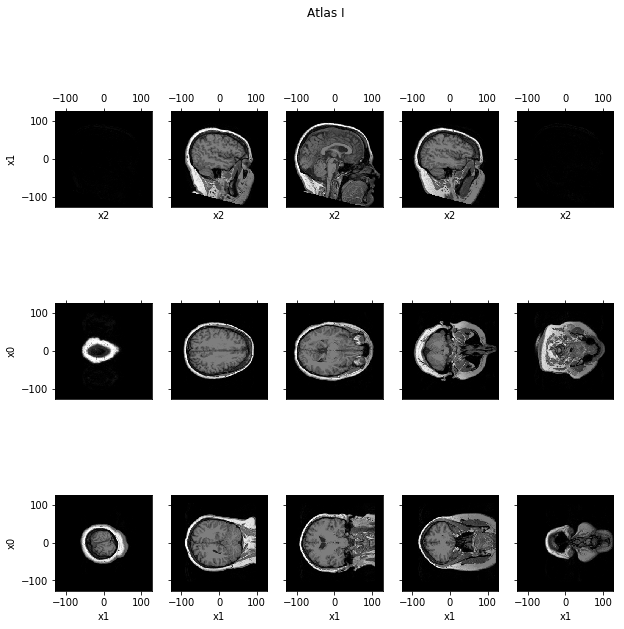

In [10]:
# display the data
f = plt.figure(figsize=(10,10))
vis.imshow_slices(I, x=xI, fig=f)
f.suptitle('Atlas I')
f.canvas.draw()

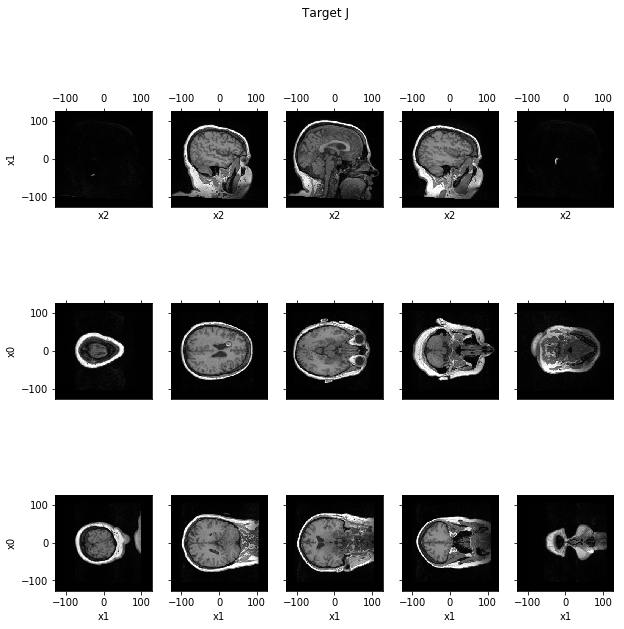

In [11]:
f = plt.figure(figsize=(10,10))
vis.imshow_slices(J,x=xJ,fig=f)
f.suptitle('Target J')
f.canvas.draw()

# Apply Brain Mask

In [12]:
brainmask_fname = "/home/adam2392/hdd/data/neuroimaging/freesurfer_output/outputfiles/la03/brainmask.mgz"

brainmask_img = nib.load(brainmask_fname)

(256, 256, 256)
[256 256 256] [1. 1. 1.]


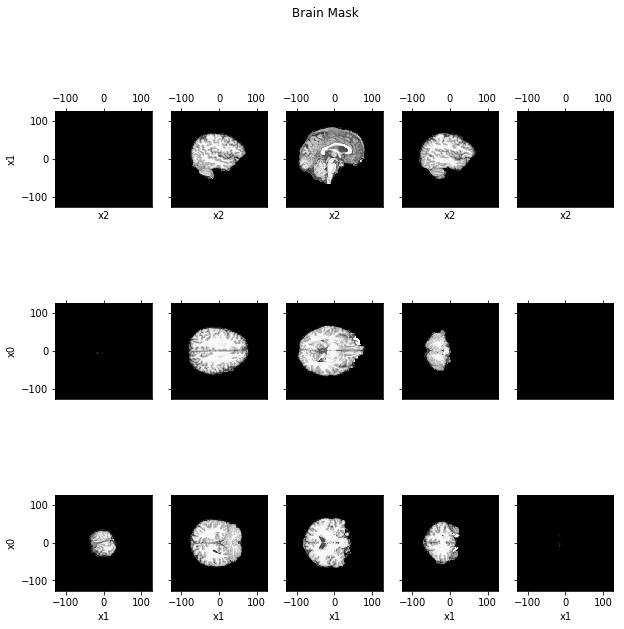

In [13]:
B = brainmask_img.get_data()

print(B.shape)

nxI = brainmask_img.header['dims'][0:3]
dxI = brainmask_img.header['delta']
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]

print(nxI, dxI)
# display the data
f = plt.figure(figsize=(10,10))
vis.imshow_slices(B, x=xI, fig=f)
f.suptitle('Brain Mask')
f.canvas.draw()

[0 1]


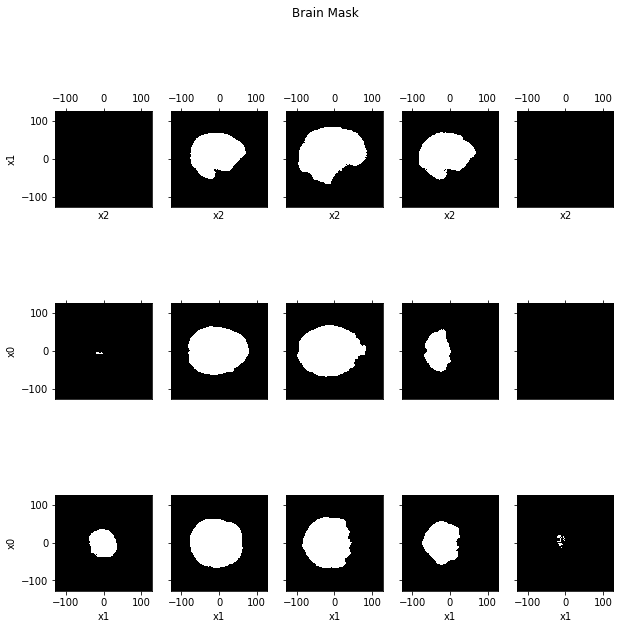

In [14]:
# apply thresholding B
B[B > 0] = 1

print(np.unique(B))

# display the data
f = plt.figure(figsize=(10,10))
vis.imshow_slices(B, x=xI, fig=f)
f.suptitle('Brain Mask')
f.canvas.draw()

In [15]:
print(I.shape, J.shape, B.shape)

(256, 256, 256) (256, 256, 256) (256, 256, 256)


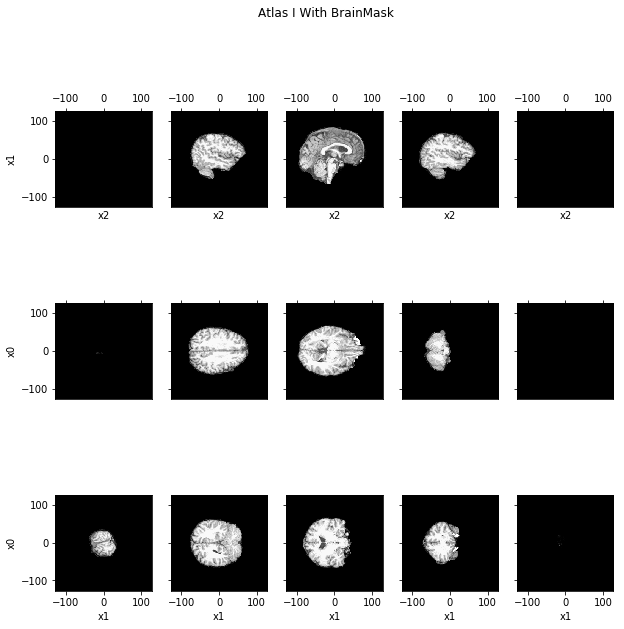

In [16]:
# display the data
f = plt.figure(figsize=(10,10))
vis.imshow_slices(np.multiply(I, B), x=xI, fig=f)
f.suptitle('Atlas I With BrainMask')
f.canvas.draw()

In [17]:
Imasked = np.multiply(I, B)

print(Imasked.shape)

(256, 256, 256)


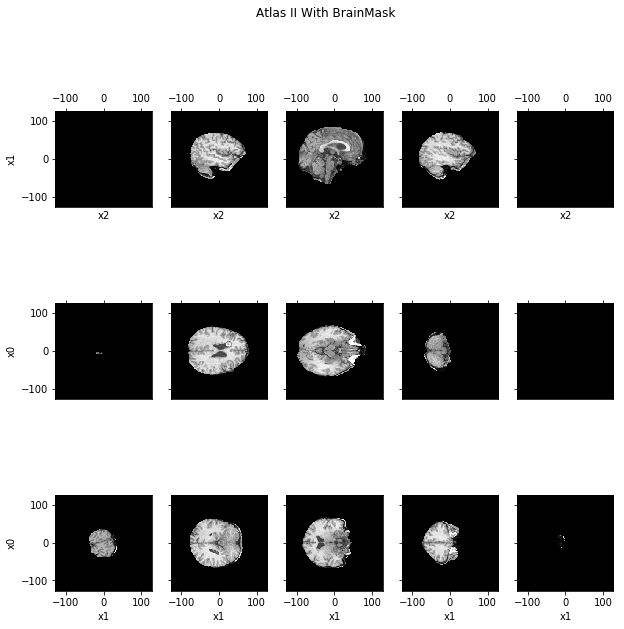

In [18]:
Jmasked = np.multiply(J, B)
# display the data
f = plt.figure(figsize=(10,10))
vis.imshow_slices(Jmasked, x=xI, fig=f)
f.suptitle('Atlas II With BrainMask')
f.canvas.draw()

/home/adam2392/Documents/neuroimg_pipeline/image_lddmm_tensorflow/.venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


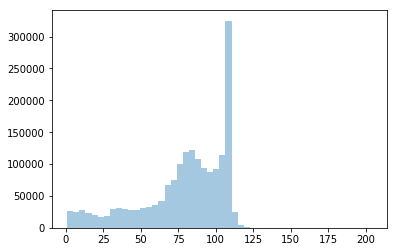

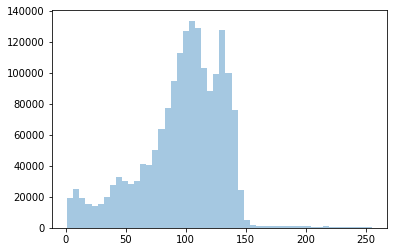

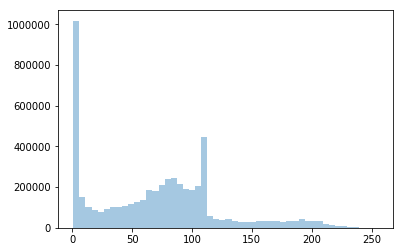

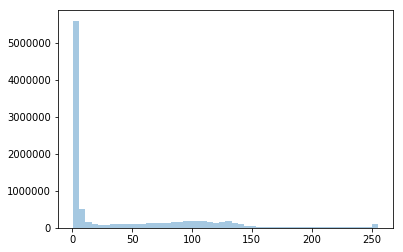

In [19]:
plt.figure()
sns.distplot(Imasked[np.where(Imasked > 0)], kde=False)

plt.figure()
sns.distplot(Jmasked[np.where(Jmasked > 0)], kde=False)


plt.figure()
sns.distplot(I[np.where(I > 0)], kde=False)

plt.figure()
sns.distplot(J[np.where(J > 0)], kde=False)

# Apply Binarization Volume Algorithm

Once volumes are coregistered and subtracted from each other, then we can binarize the volume. The volumes that survive this threshold algo, then is equivalent to the voxel volume of the ablation/resection.


In [46]:
Imasked = np.multiply(I, B)
Jmasked = np.multiply(J, B)

In [41]:
print(Imasked.shape, Jmasked.shape)
Jmasked[Jmasked > 120] = 1
Imasked[Imasked > 120] = 1

Imasked[Imasked > 0] = 1
Jmasked[Jmasked > 0] = 1

(256, 256, 256) (256, 256, 256)


In [55]:
binarized_vol = np.subtract(Imasked,Jmasked)
binarized_vol[binarized_vol > 100] = 0

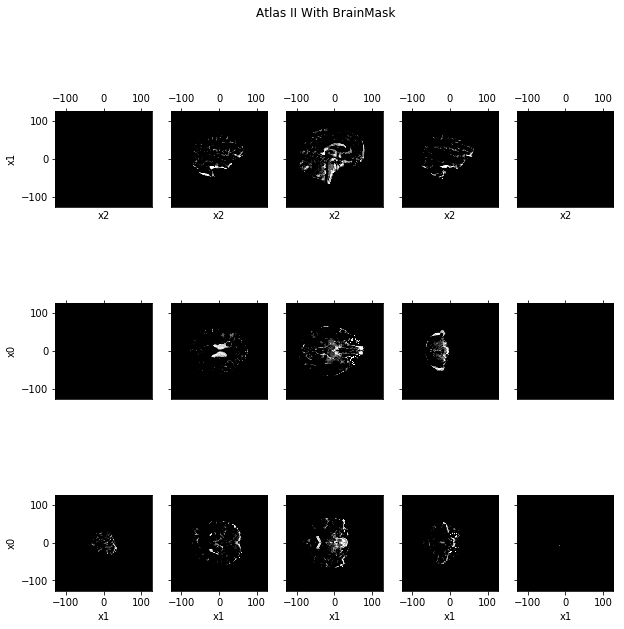

In [56]:
# display the data
f = plt.figure(figsize=(10,10))
vis.imshow_slices(binarized_vol, x=xI, fig=f)
f.suptitle('Atlas II With BrainMask')
f.canvas.draw()

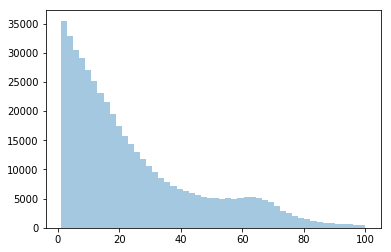

In [57]:
plt.figure()
sns.distplot(binarized_vol[np.where(binarized_vol > 0)], kde=False)


In [50]:
print(np.linalg.norm(binarized_vol))
print(np.sum(binarized_vol))

256360.44976750997
301006061


In [62]:
binimg = nib.Nifti1Image(binarized_vol, img[0].affine)
nib.save(binimg, "/home/adam2392/Downloads/test.mgz")